In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func 
from matplotlib import style
style.use('seaborn')

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
s_data = pd.read_sql("SELECT*FROM Station", conn)
s_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [11]:
m_data = pd.read_sql("SELECT*FROM Measurement", conn)
m_data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [12]:
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day

('2017-08-23')

In [13]:
prec = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>='2016-08-23').all()
prec = pd.DataFrame(prec, columns = ["Date", "Precipitation"]).set_index(["Date"]).sort_values(by="Date", ascending=True)
prec.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


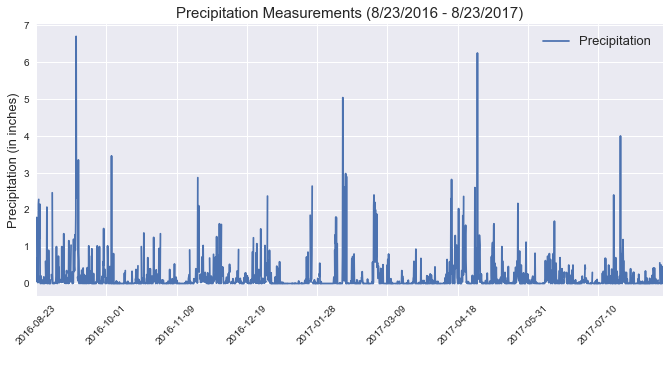

In [14]:
prec.plot(figsize=(10,5))
plt.title("Precipitation Measurements (8/23/2016 - 8/23/2017)",size=15)
plt.ylabel("Precipitation (in inches)", size =13)
plt.xticks(rotation=45)
plt.xlabel("Date",color='w')
plt.legend(loc = "upper right",prop={'size':13})
plt.show()

In [15]:
prec = session.query(Measurement.prcp).filter(Measurement.date>='2016-08-23').all()
prec = pd.DataFrame(prec, columns = ["Precipitation"])
prec.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
session.query(Station.station).count()

9

In [17]:
# Most active stations.
prec = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
prec

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# lowest, highest and average temperature for the most active station
low_high_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
low_high_avg

[(54.0, 85.0, 71.66378066378067)]

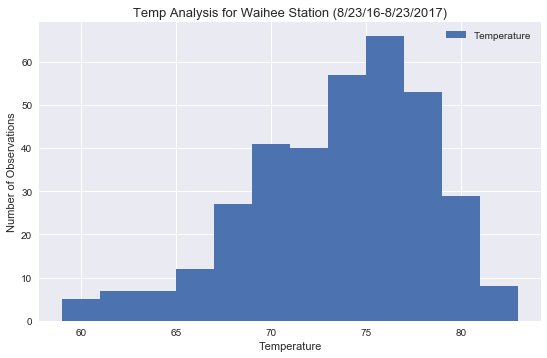

In [19]:
# Last 12 months of temperature observation data for the most active station.
most_active_station = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date>='2016-08-23').all()
most_active_station = pd.DataFrame(most_active_station, columns = ["Temperature"])
most_active_station.plot.hist(bins=12)
plt.title("Temp Analysis for Waihee Station (8/23/16-8/23/2017)", size=13)
plt.ylabel("Number of Observations")
plt.xlabel("Temperature")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,3,9)-dt.timedelta(days=365)
prev_year_end = dt.date(2018,3,16)-dt.timedelta(days=365)
tmin,tavg,tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
tmin,tavg,tmax

(65.0, 71.45098039215686, 82.0)

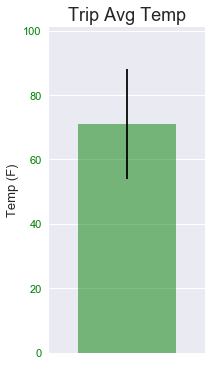

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# data to plot
# Your x and y axis
# Your x and y axis
N = 1
avg_temp = (71)
min_max_dif = (17)

ind = np.arange(N)
plt.subplots(figsize = (2.5,6))
plt.bar(ind, avg_temp, color='g', yerr=min_max_dif, alpha=0.5)
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,     
    labelbottom=False)
plt.margins(0.3,0.15)
plt.grid(axis='x')
plt.ylabel('Temp (F)', fontsize = 13)
plt.yticks(fontsize = 11, color = "g")
plt.title('Trip Avg Temp',  fontsize = 18)

plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=prev_year_start).filter(Measurement.date<=prev_year_end)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_per_station)                                        

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.9600000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.75), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.63), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.01), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [9]:
# Plot the daily normals as an area plot with `stacked=False`